# Example 07 - Sig53 with YOLOv8 Classifier
This notebook showcases using the Sig53 dataset to train a YOLOv8 classification model.

---

## Import Libraries
We will import all the usual libraries, in addition to Ultralytics. You can install Ultralytics with:
```bash
pip install ultralytics
```

In [1]:
# Packages for Training
from torchsig.utils.yolo_classify import *
from torchsig.utils.classify_transforms import real_imag_vstacked_cwt_image, complex_iq_to_heatmap
import yaml
from PIL import Image

In [8]:
# Packages for testing/inference
from torchsig.datasets.modulations import ModulationsDataset
from torchsig.transforms.target_transforms import DescToFamilyName
from torchsig.transforms.transforms import Spectrogram, SpectrogramImage, Normalize, Compose, Identity
from ultralytics import YOLO
from PIL import Image

## Prepare YOLO classificatoin trainer and Model
Datasets are generated on the fly in a way that is Ultralytics YOLO compatible. See [Ultralytics: Train Custom Data - Organize Directories](https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#23-organize-directories) to learn more. 

Additionally, we create a yaml file for dataset configuration. See "classify.yaml" in Torchsig Examples.

Download desired YOLO model from [Ultralytics Models](https://docs.ultralytics.com/models/). We will use YOLOv8, specifically `yolov8n-cls.pt`

---

In [3]:
config_path = 'classify.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

overrides = config['overrides']

### Explanation of the `overrides` Dictionary

The `overrides` dictionary is used to customize the settings for the Ultralytics YOLO trainer by specifying specific values that override the default configurations. The dictionary is imported from `classify.yaml`. However, you can customize in the notebook. 

Example:

```python
overrides = {'model': 'yolov8n-cls.pt', 'epochs': 100, 'data': 'classify.yaml', 'device': 0, 'imgsz': 64}
```
A .yaml is necessary for training. Look at `classify.yaml` in the examples directory. It will contain the path to your torchsig data.

### Explanation of `image_transform` function
`YoloClassifyTrainer` allows you to pass in any transform that takes in complex I/Q and outputs an image for training. Some example transforms can be found in torchsig.utils.classify_transforms. If nothing is passed, it will default to spectrogram images. It is important to update `overrides` so that your imgsz matches output.

### Build YoloClassifyTrainer
This will instantiate the YOLO classification trainer with overrides specified above.

In [4]:
trainer = YoloClassifyTrainer(overrides=overrides, image_transform=None)

Ultralytics YOLOv8.2.77 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:1 (NVIDIA A100-SXM4-80GB, 81038MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=classify.yaml, epochs=1, time=None, patience=100, batch=32, imgsz=64, save=True, save_period=-1, cache=False, device=1, workers=32, project=YOUR_PROJECT_NAME, name=YOUR_CLASSIFY_EXPERIMENT, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

### The will begin training

In [5]:
trainer.train()

TensorBoard: Start with 'tensorboard --logdir YOUR_PROJECT_NAME/YOUR_CLASSIFY_EXPERIMENT', view at http://localhost:6006/
Overriding model.yaml nc=1000 with nc=53

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  

/usr/local/lib/python3.10/dist-packages/ultralytics/engine/trainer.py:271: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)


args -> classify.yaml
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 64 train, 64 val
Using 32 dataloader workers
Logging results to YOUR_PROJECT_NAME/YOUR_CLASSIFY_EXPERIMENT
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 10.47it/s]


                   all     0.0377      0.119

1 epochs completed in 0.002 hours.
validator data -> classify.yaml
Optimizer stripped from YOUR_PROJECT_NAME/YOUR_CLASSIFY_EXPERIMENT/weights/last.pt, 3.1MB
Optimizer stripped from YOUR_PROJECT_NAME/YOUR_CLASSIFY_EXPERIMENT/weights/best.pt, 3.1MB

Validating YOUR_PROJECT_NAME/YOUR_CLASSIFY_EXPERIMENT/weights/best.pt...
Ultralytics YOLOv8.2.77 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81038MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,502,773 parameters, 0 gradients, 3.3 GFLOPs


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:00<00:00, 150.06it/s]


                   all     0.0245     0.0943
Speed: 0.0ms preprocess, 0.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to YOUR_PROJECT_NAME/YOUR_CLASSIFY_EXPERIMENT
Results saved to YOUR_PROJECT_NAME/YOUR_CLASSIFY_EXPERIMENT


### Instantiate Test Dataset

Uses Torchsig's `ModulationsDataset` to generate a narrowband classification dataset. 

In [6]:
# Determine whether to map descriptions to family names
if config['family']:
    target_transform = CP([DescToFamilyName()])
else:
    target_transform = None

transform = Compose([
    Spectrogram(nperseg=overrides['imgsz'], noverlap=0, nfft=overrides['imgsz'], mode='psd'),
    Normalize(norm=np.inf, flatten=True),
    SpectrogramImage(), 
    ])

class_list = [item[1] for item in config['names'].items()]

dataset = ModulationsDataset(
    classes=class_list,
    use_class_idx=False,
    level=config['level'],
    num_iq_samples=overrides['imgsz']**2,
    num_samples=int(config['nc'] * 10),
    include_snr=config['include_snr'],
    transform=transform,
    target_transform=target_transform
)

# Retrieve a sample and print out information
idx = np.random.randint(len(dataset))
data, label = dataset[idx]
print("Dataset length: {}".format(len(dataset)))
print("Data shape: {}".format(data.shape))

samples = []
labels = []
for i in range(10):
    idx = np.random.randint(len(dataset))
    sample, label = dataset[idx]
    samples.append(sample)
    labels.append(label)

Dataset length: 530
Data shape: (64, 64, 3)


### Predictions / Inference
The following cells show you how to load the 'best.pt' weights from your training for prediction

In [9]:
model_path = 'YOUR_PROJECT_NAME/YOUR_CLASSIFY_EXPERIMENT/weights/best.pt'  #replace with your path to 'best.pt'
model = YOLO(model_path) #The model will remember the configuration from training

In [21]:
results = model.predict(samples)


0: 64x64 16pam 0.03, 4msk 0.03, ofdm-300 0.03, 8psk 0.03, 4pam 0.03, 0.4ms
1: 64x64 32psk 0.03, 1024qam 0.03, 4msk 0.03, 64qam 0.03, 8psk 0.03, 0.4ms
2: 64x64 ofdm-300 0.04, ofdm-1024 0.03, 8psk 0.03, 2fsk 0.03, ofdm-180 0.03, 0.4ms
3: 64x64 64qam 0.03, 32psk 0.03, 128qam_cross 0.03, ofdm-900 0.03, 8gmsk 0.03, 0.4ms
4: 64x64 ofdm-300 0.06, 16gfsk 0.05, 8fsk 0.03, 4msk 0.03, 16pam 0.03, 0.4ms
5: 64x64 32psk 0.03, 64qam 0.03, 16fsk 0.02, 8gmsk 0.02, 16psk 0.02, 0.4ms
6: 64x64 ofdm-300 0.04, 16psk 0.03, 4msk 0.03, 32qam 0.03, 16pam 0.03, 0.4ms
7: 64x64 32psk 0.03, 16fsk 0.03, 32qam_cross 0.03, 64qam 0.03, ofdm-300 0.03, 0.4ms
8: 64x64 16pam 0.04, 4msk 0.03, 16psk 0.03, 16ask 0.03, ofdm-300 0.03, 0.4ms
9: 64x64 64qam 0.03, 32psk 0.03, 8gmsk 0.02, 32qam_cross 0.02, 1024qam 0.02, 0.4ms
Speed: 0.5ms preprocess, 0.4ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


Actual Labels -> ofdm-600
Top 1 Prediction ->  16pam, 0.03368053212761879
Top 5 Prediction ->  16pam,4msk,ofdm-300,8psk,4pam, [0.033680532, 0.030430196, 0.029595297, 0.029319366, 0.027798675]


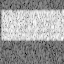

Actual Labels -> 64ask
Top 1 Prediction ->  32psk, 0.034033387899398804
Top 5 Prediction ->  32psk,1024qam,4msk,64qam,8psk, [0.034033388, 0.02703341, 0.025372362, 0.025346853, 0.02519393]


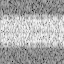

Actual Labels -> ofdm-512
Top 1 Prediction ->  ofdm-300, 0.036741953343153
Top 5 Prediction ->  ofdm-300,ofdm-1024,8psk,2fsk,ofdm-180, [0.036741953, 0.026457129, 0.026435416, 0.025381025, 0.025223134]


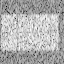

Actual Labels -> ofdm-900
Top 1 Prediction ->  64qam, 0.029625799506902695
Top 5 Prediction ->  64qam,32psk,128qam_cross,ofdm-900,8gmsk, [0.0296258, 0.027955513, 0.027107207, 0.02672575, 0.025072215]


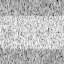

Actual Labels -> 4pam
Top 1 Prediction ->  ofdm-300, 0.0609188973903656
Top 5 Prediction ->  ofdm-300,16gfsk,8fsk,4msk,16pam, [0.060918897, 0.04688027, 0.034186676, 0.030456385, 0.029908646]


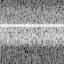

Actual Labels -> 16qam
Top 1 Prediction ->  32psk, 0.030685605481266975
Top 5 Prediction ->  32psk,64qam,16fsk,8gmsk,16psk, [0.030685605, 0.026008802, 0.024897756, 0.02345956, 0.023073435]


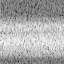

Actual Labels -> ofdm-512
Top 1 Prediction ->  ofdm-300, 0.03914753720164299
Top 5 Prediction ->  ofdm-300,16psk,4msk,32qam,16pam, [0.039147537, 0.028814971, 0.028565336, 0.026398636, 0.026259989]


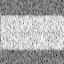

Actual Labels -> 32psk
Top 1 Prediction ->  32psk, 0.03091914765536785
Top 5 Prediction ->  32psk,16fsk,32qam_cross,64qam,ofdm-300, [0.030919148, 0.02701051, 0.026937515, 0.026757663, 0.026381968]


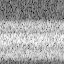

Actual Labels -> ofdm-72
Top 1 Prediction ->  16pam, 0.04030076786875725
Top 5 Prediction ->  16pam,4msk,16psk,16ask,ofdm-300, [0.040300768, 0.03465414, 0.03413951, 0.032029744, 0.031986356]


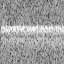

Actual Labels -> qpsk
Top 1 Prediction ->  64qam, 0.027023477479815483
Top 5 Prediction ->  64qam,32psk,8gmsk,32qam_cross,1024qam, [0.027023477, 0.025516286, 0.023688382, 0.023669185, 0.023428323]


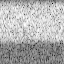

In [57]:
# Process results list
for y, result in enumerate(results):
    probs = result.probs  # Probs object for classification outputs
    print(f'Actual Labels -> {labels[y]}')
    print(f'Top 1 Prediction ->  {result.names[probs.top1]}, {probs.top1conf}')
    print(f'Top 5 Prediction ->  {result.names[probs.top5[0]]},{result.names[probs.top5[1]]},{result.names[probs.top5[2]]},{result.names[probs.top5[3]]},{result.names[probs.top5[4]]}, {list(probs.top5conf.cpu().numpy())}')

    img = Image.fromarray(result.orig_img)
    img.show()# display to screen
